In [1]:


#LIB IMPORTATIONS
"****************************************************"

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
from numba import jit, njit
from time import time
from statsmodels.distributions import ECDF
import seaborn as sns
from sklearn.preprocessing import normalize
import collections as collec
from scipy.interpolate import UnivariateSpline
import os



'****************************************************'

######### GLOBAL VARIABLES


DATA_NAMES =  [f'../data/orderbooks_{part}/orderbooks-5limits-part{i}.parquet' for part in [1,2] for i in range(1,27) ]



### SYNTHETIC-ORDER VARIABLES
TIME_BETWEEN_ORDERS = 1 #second
DISTANCE_PLACED_ORDERS = 0  #bps
LIFETIME_ORDERS = 1.01


### VOLUME-VARIATION VARIABLES
MIN_DEPTH_BPS = 1
MAX_DEPTH_BPS= 15
NUMBER_OF_LEVELS = 11
DELTA_EVENTS = 10 


MIN_EVENTS = 200
MAX_EVENTS = 700

NUMBER_OF_EVENTS = 11

DELTA_EVENTS_LIST = [round(i) for i in np.linspace(MIN_EVENTS, MAX_EVENTS, NUMBER_OF_EVENTS) ]
NUM_BUCKETS = 16

DEPTHS  = [round(i,1) for i in np.linspace(MIN_DEPTH_BPS, MAX_DEPTH_BPS, NUMBER_OF_LEVELS) ] #[1, 2, 5, 10, 20, 50, 100]





In [2]:
print(DEPTHS)
print(DELTA_EVENTS_LIST)

[1.0, 2.4, 3.8, 5.2, 6.6, 8.0, 9.4, 10.8, 12.2, 13.6, 15.0]
[200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]


Index(['etimestamp', 'eprice', 'etype', 'esize_ini', 'eside', 'bp0', 'bq0',
       'bp1', 'bq1', 'bp2', 'bq2', 'bp3', 'bq3', 'bp4', 'bq4', 'ap0', 'aq0',
       'ap1', 'aq1', 'ap2', 'aq2', 'ap3', 'aq3', 'ap4', 'aq4'],
      dtype='object')

In [3]:


def get_volume_differences(row, line, data, delta_events = DELTA_EVENTS
                           ): 
    
    
    
    depths_to_sides_to_added_liquidity = {depth:{'B':0 , 'S': 0} for depth in DEPTHS}
    current_time_ = row[0] #timestamp
    iter_line = line 
    events_looked_at=0
    data_iter_line = row
    limit_order_memory = []
    #first_event_line  = line - delta_events
    while events_looked_at < delta_events :
        iter_line -= 1
        if iter_line < 0 : 
            break
        #if (data_iter_line[2] != 'A') or data_iter_line[-1] == True : #order_type and marketable = False
            #data_iter_line = data[iter_line]
            #continue
        if data_iter_line[0] ==  row[0]:
            data_iter_line = data[iter_line]
            continue

        events_looked_at += 1
        limit_order_memory.append(
            {'price' : data_iter_line[1], #eprice
             'side' : data_iter_line[4], #eside
             'volume': data_iter_line[3] #esize_ini
             })
        data_iter_line = data[iter_line]
    

    
    depths_to_sides_to_prices_ini = {depth :
                                     {'B' : data_iter_line[5] *(1 - depth / 10_000) , 'S' : data_iter_line[15]* (1 + depth / 10_000) } 
                                     for depth in DEPTHS} #best bid, best_ask
    

    for limit_order in limit_order_memory : 
        trade_side = limit_order['side']
        for depth in DEPTHS : 
            sides_to_prices_ini = depths_to_sides_to_prices_ini[depth]
            
            if ((trade_side == 'B') and (limit_order['price'] >= sides_to_prices_ini['B'])) or (
                (trade_side == 'S') and (limit_order['price'] <= sides_to_prices_ini['S'])) :
                depths_to_sides_to_added_liquidity[depth][trade_side] += limit_order['volume']
        


    return depths_to_sides_to_added_liquidity
    
    


def get_diff_imbalance(vol_bid_diff, vol_ask_diff):

    if vol_bid_diff + vol_ask_diff == 0 :
        return 0
    
    imbalance =  (vol_bid_diff - vol_ask_diff) / (vol_bid_diff + vol_ask_diff)
    return imbalance





def get_differences_imbalances(depths_to_sides_to_added_liquidity):
    

    depths_to_imbalances = {depth : get_diff_imbalance(depths_to_sides_to_added_liquidity[depth]['B'],
                                                               depths_to_sides_to_added_liquidity[depth]['S'])
                                                               for depth in DEPTHS}
    
    return depths_to_imbalances 

In [4]:
def get_orders_data3(
        distance_bps = DISTANCE_PLACED_ORDERS,
        delay = LIFETIME_ORDERS, 
        data = DATA_NAMES, 
        time_between_orders = TIME_BETWEEN_ORDERS, 
        delta_events = DELTA_EVENTS):
    
    
    timestamp_start_to_feature_to_value = {}
    order_id = 0
    trade_maker_sides, trade_prices, trade_timestamps = [], [], []
    
    
    num_iter = 0
   
    
    last_order_snapshot = -1
    number_of_posted_orders = 0
    tradecimetery_to_features_to_values = []
    t_very_start=time()

    for name in DATA_NAMES: 
        t_start = time()
        
        data=pd.read_parquet(name)
        cols = [f'{lettre}{typ}{lev}' for lettre in ['b','a'] for lev in range(5) for typ in ['p','q'] ]
        data = data[['etimestamp','eprice', 'etype', 'esize_ini', 'eside'] + cols +['is_from_marketable']]
        dataloc = data.values
        length = len(dataloc)
        start_time=dataloc[0][0]
        
        

        for line, row in enumerate(dataloc): # we iterate over the whole dataset


            num_iter += 1
            current_time=row[0] #timestamp

            line_prov=line
            while dataloc[line_prov,0] == current_time: # We look at all the trade orders that happened at the same timestamp as the current
                dataloc_line_prov = dataloc[line_prov]
                if dataloc_line_prov[2] == 'T': 
                    
                    trade_maker_sides.append(dataloc_line_prov[4]) #eside
                    trade_timestamps.append(current_time)
                    trade_prices.append(dataloc_line_prov[1]) #eprice

                line_prov += 1
                if line_prov==length:
                    break
        
            if row[0] - last_order_snapshot > time_between_orders : # it has been more than a second since the last order was placed
                if line <= delta_events:
                    continue 
                
                if row[5] < row[15]:
                    
                     # We check if not in a particular case of bid > ask, and then post an order (we don't take volumes into account)
                    number_of_posted_orders += 2
                    synthetic_bid_order = row[5] * (1 - distance_bps / 10_000) #bp0
                    synthetic_ask_order = row[15] * (1 + distance_bps / 10_000) #ap0
                    depths_to_sides_to_added_liquidity = get_volume_differences(row, line, dataloc, delta_events)
                    depths_to_imbalances = get_differences_imbalances(depths_to_sides_to_added_liquidity)
                    
                    #print(depths_to_imbalances)
                    # Recording the features
                    bid_order_feature_to_value = {
                        "side": "B",
                        "price": synthetic_bid_order,
                        "order_id": order_id,
                        "timestamp_insertion": row[0], #timsestamp
                        "lifetime": delay,
                        "executed": 'pending'
                    }
                    order_id += 1
                    ask_order_feature_to_value = {
                        "side": "S",
                        "price": synthetic_ask_order,
                        "order_id": order_id,
                        "timestamp_insertion": row[0] + 1e-6, #to avoid doubles in our dataframes
                        "lifetime": delay,
                        "executed": 'pending'
                    }
                    order_id+=1

                    for depth in DEPTHS :
                        
                        imbalance= depths_to_imbalances[depth]
                        bid_order_feature_to_value[f'imbalance_{depth}_bps'] = imbalance
                        ask_order_feature_to_value[f'imbalance_{depth}_bps'] = imbalance

                    
                    timestamp_start_to_feature_to_value[ask_order_feature_to_value["timestamp_insertion"]] = ask_order_feature_to_value # posting the ask order
                    timestamp_start_to_feature_to_value[bid_order_feature_to_value["timestamp_insertion"]] = bid_order_feature_to_value # posting the bid order


                    # Matching engine
                    for k in range(len(trade_prices)):
                        trade_feature_to_value = {
                            "side": trade_maker_sides[k],
                            "price": trade_prices[k],
                            "timestamp": trade_timestamps[k],
                        }
                        #if trade_feature_to_value['side'] == 'S':
                            #print('***',trade_feature_to_value['timestamp'])
                        j=0
                        while True:
                            if j >= len(timestamp_start_to_feature_to_value):
                                break

                            timestamp_start = list(timestamp_start_to_feature_to_value.keys())[j]
                            feature_to_value = timestamp_start_to_feature_to_value[timestamp_start]

                            if (current_time > feature_to_value['timestamp_insertion'] + feature_to_value['lifetime']): #the order is dead


                                feature_to_value['executed'] = False
                                feature_to_value['lifetime']=current_time - feature_to_value['timestamp_insertion']
                                tradecimetery_to_features_to_values.append(feature_to_value)
                                del timestamp_start_to_feature_to_value[timestamp_start]
                                j-=1
                            elif (trade_feature_to_value['side'] == feature_to_value['side']) & (current_time > feature_to_value['timestamp_insertion']):
                               
                                if(((trade_feature_to_value['side'] == 'B') & (feature_to_value['price'] >= trade_feature_to_value['price'])) 
                                or ( (trade_feature_to_value['side'] == 'S') & (feature_to_value['price'] <= trade_feature_to_value['price']))):
                                
                                    feature_to_value['executed'] = True
                                    feature_to_value['lifetime']= current_time - feature_to_value['timestamp_insertion']
                                    tradecimetery_to_features_to_values.append(feature_to_value)
                                    del timestamp_start_to_feature_to_value[timestamp_start]
                                    j-=1
                            j+=1
                    trade_maker_sides, trade_prices, trade_timestamps = [], [], []
                    


                last_order_snapshot=row[0]  #timestamp
        del data
        del dataloc
        
        
        print(f'calculated exec data of {name} for delta event of {delta_events} events in {round(time() - t_start, 2)}s')
        print(f'total time : {round(time()- t_very_start ,2)}')
    

    return tradecimetery_to_features_to_values

In [5]:
def get_exec_numbers(**kwargs):
    
    results = get_orders_data3(**kwargs)
                              
    NUM_BUCKETS = 30
    bucket_increment = 2/NUM_BUCKETS

    limits_to_bucket = {
        round(-1+  bucket_increment * (i + 0.5) , 2) : {
            'min_': round(-1 + bucket_increment * i, 2) ,
            'max_' : round(-1 + bucket_increment * (i + 1), 2) } 
            for i in range(NUM_BUCKETS) }
    
    levels_to_buckets_to_bid_orders_to_executed = {level_ :
                                                 {round(-1+  bucket_increment * (i + 0.5), 2): {'executed' : 0 , 'total_bucket' : 0} 
                                                  for i in range (NUM_BUCKETS)}
                                                  for level_ in DEPTHS
                                                 }
    levels_to_buckets_to_ask_orders_to_executed = {level_ :
                                                 {round(-1+  bucket_increment * (i + 0.5), 2): {'executed' : 0 , 'total_bucket' : 0} 
                                                  for i in range (NUM_BUCKETS)}
                                                  for level_ in DEPTHS
                                                 } 

    for trade in results: 
        

        for _, level in enumerate(DEPTHS) :
            imbalance = trade[f'imbalance_{level}_bps']
           
        
            correct_middle = np.NaN
            for middle in limits_to_bucket.keys(): 
                bucket = limits_to_bucket[middle]
                if ((bucket['min_'] <= imbalance) & (bucket['max_'] >= imbalance)) : 
                    correct_middle = middle
                    break

            if trade['side'] == 'B':
                buckets_to_bid_orders_to_executed = levels_to_buckets_to_bid_orders_to_executed[level][correct_middle]

                buckets_to_bid_orders_to_executed['total_bucket'] += 1
                if trade['executed'] == True: 
                    buckets_to_bid_orders_to_executed['executed'] += 1
            else :
                buckets_to_ask_orders_to_executed = levels_to_buckets_to_ask_orders_to_executed[level][correct_middle]
                buckets_to_ask_orders_to_executed['total_bucket'] += 1
                if trade['executed'] == True: 
                    buckets_to_ask_orders_to_executed['executed'] += 1


    
        

    return levels_to_buckets_to_ask_orders_to_executed, levels_to_buckets_to_bid_orders_to_executed








def get_exec_probas(**kwargs):
    
    

    levels_to_buckets_to_ask_orders_to_executed, levels_to_buckets_to_bid_orders_to_executed = get_exec_numbers(**kwargs)
       

    levels_to_buckets_to_ask_probas = {level:{} for level in DEPTHS}
    levels_to_buckets_to_bid_probas = {level:{} for level in DEPTHS}
    timestamps = levels_to_buckets_to_ask_orders_to_executed[DEPTHS[0]].keys()
    for key in timestamps:
        for level in levels_to_buckets_to_ask_orders_to_executed.keys():
            doc_ask=levels_to_buckets_to_ask_orders_to_executed[level][key]
            doc_bid=levels_to_buckets_to_bid_orders_to_executed[level][key]
            total_bucket = doc_ask['total_bucket']
           
            levels_to_buckets_to_ask_probas[level][key] = doc_ask['executed']/(total_bucket) if total_bucket != 0 else 0
            levels_to_buckets_to_bid_probas[level][key] = doc_bid['executed']/(total_bucket) if total_bucket !=0 else 0



    return levels_to_buckets_to_bid_probas, levels_to_buckets_to_ask_probas


In [6]:
def get_all_data(distance_bps = 0, 
                delay = LIFETIME_ORDERS, 
                data = DATA_NAMES, 
                time_between_orders = TIME_BETWEEN_ORDERS, 
                delta_events_list = DELTA_EVENTS_LIST):
        
   sides_to_deltas_to_levels_to_buckets_to_probas={'B':{} ,'S':{}}


   for delta_event in delta_events_list :
      print('starting calculation for', delta_event, 'events')
      levels_to_buckets_to_bid_probas, levels_to_buckets_to_ask_probas= get_exec_probas(
         distance_bps = distance_bps, 
         delay = delay, 
         data = data,
         time_between_orders = time_between_orders, 
         delta_events = delta_event)
      sides_to_deltas_to_levels_to_buckets_to_probas['B'][delta_event] = levels_to_buckets_to_bid_probas
      sides_to_deltas_to_levels_to_buckets_to_probas['S'][delta_event] = levels_to_buckets_to_ask_probas





   return  sides_to_deltas_to_levels_to_buckets_to_probas





In [7]:
def get_heatmap_data(sides_to_deltas_to_levels_to_buckets_to_probas):


    heat_map_data_bid, heat_map_data_ask=[],[]

    deltas_to_levels_to_buckets_to_probas_ask = sides_to_deltas_to_levels_to_buckets_to_probas['S']
    deltas_to_levels_to_buckets_to_probas_bid = sides_to_deltas_to_levels_to_buckets_to_probas['B']


    for delta, levels_to_buckets_to_probas_bid in deltas_to_levels_to_buckets_to_probas_bid.items():
        for levels, buckets_to_probas_bid in levels_to_buckets_to_probas_bid.items():
            row_bid = pd.Series(buckets_to_probas_bid, name=(delta, levels))
            heat_map_data_bid.append(row_bid)


    for delta, levels_to_buckets_to_probas_ask in deltas_to_levels_to_buckets_to_probas_ask.items():
        for levels, buckets_to_probas_ask in levels_to_buckets_to_probas_ask.items():
            row_ask = pd.Series(buckets_to_probas_ask, name=(delta, levels))
            heat_map_data_ask.append(row_ask)  



    df_bid = pd.concat(heat_map_data_bid, axis=1).T
    df_bid.index.names = ['delta_events', 'imbalance_level']

    df_ask = pd.concat(heat_map_data_ask, axis=1).T
    df_ask.index.names = ['delta_events', 'imbalance_level']

    return df_bid, df_ask






In [8]:
df_bid_events, df_ask_events = get_heatmap_data(get_all_data(distance_bps = 0, 
                delay = LIFETIME_ORDERS, 
                data = DATA_NAMES, 
                time_between_orders = TIME_BETWEEN_ORDERS, 
                delta_events_list = DELTA_EVENTS_LIST))

df_bid_events.to_csv('../data/df_bid_for_heatmap_event.csv')
df_ask_events.to_csv('../data/df_ask_for_heatmap_event.csv')






starting calculation for 200 events
calculated exec data of ../data/orderbooks_1/orderbooks-5limits-part1.parquet for delta event of 200 events in 2.35s
total time : 2.35
calculated exec data of ../data/orderbooks_1/orderbooks-5limits-part2.parquet for delta event of 200 events in 2.05s
total time : 4.4
calculated exec data of ../data/orderbooks_1/orderbooks-5limits-part3.parquet for delta event of 200 events in 2.55s
total time : 6.94
calculated exec data of ../data/orderbooks_1/orderbooks-5limits-part4.parquet for delta event of 200 events in 2.63s
total time : 9.57
calculated exec data of ../data/orderbooks_1/orderbooks-5limits-part5.parquet for delta event of 200 events in 2.38s
total time : 11.95
calculated exec data of ../data/orderbooks_1/orderbooks-5limits-part6.parquet for delta event of 200 events in 2.43s
total time : 14.38
calculated exec data of ../data/orderbooks_1/orderbooks-5limits-part7.parquet for delta event of 200 events in 2.5s
total time : 16.88
calculated exec da

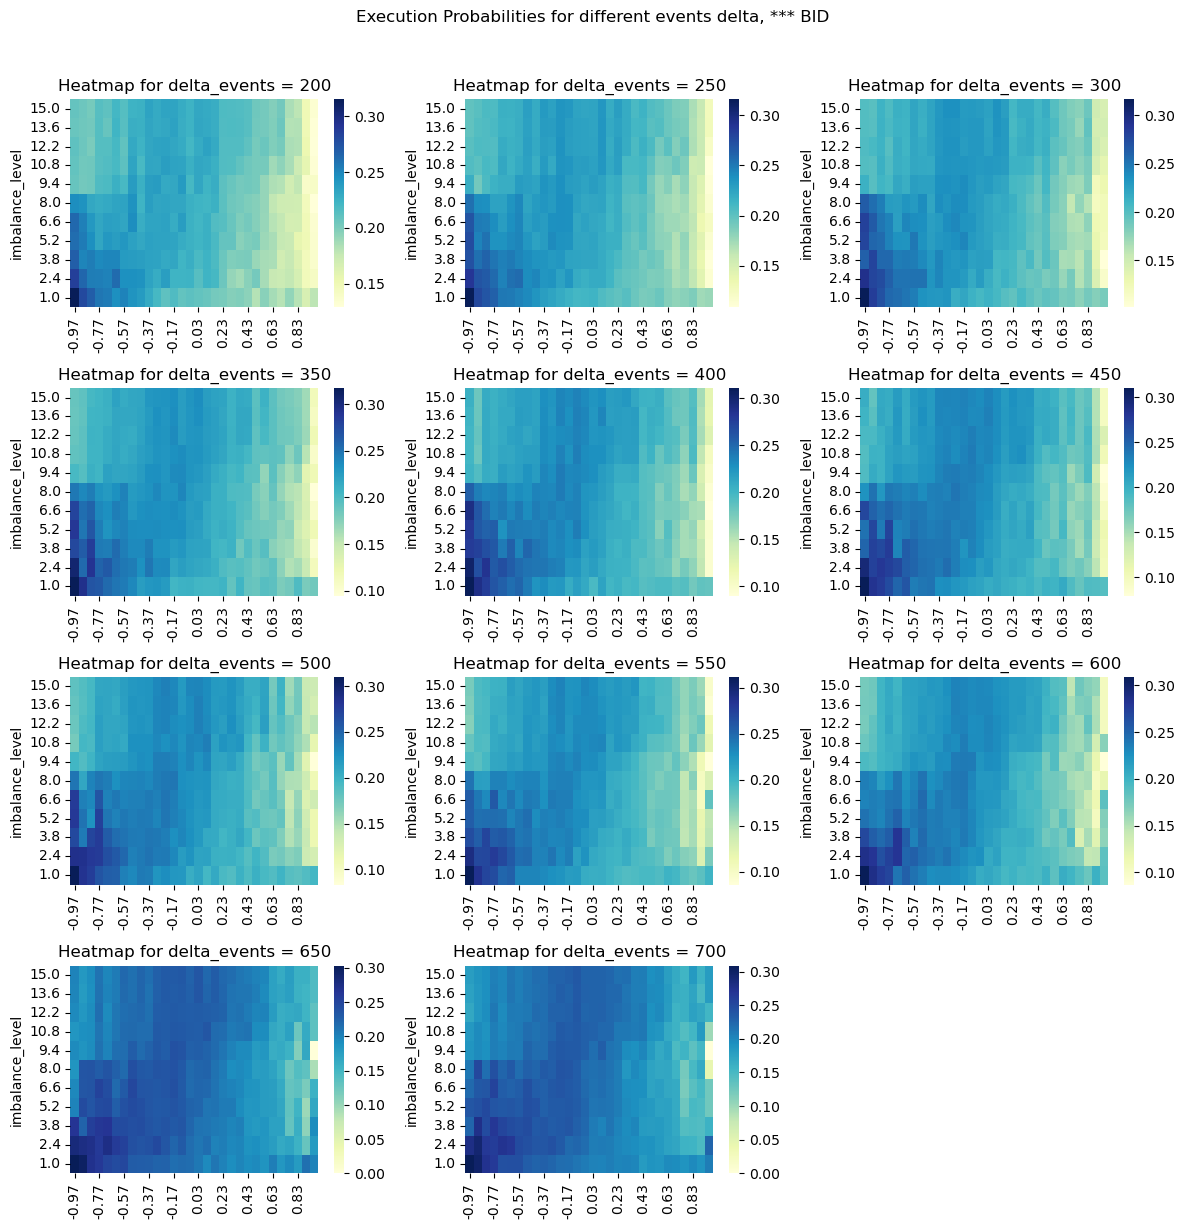

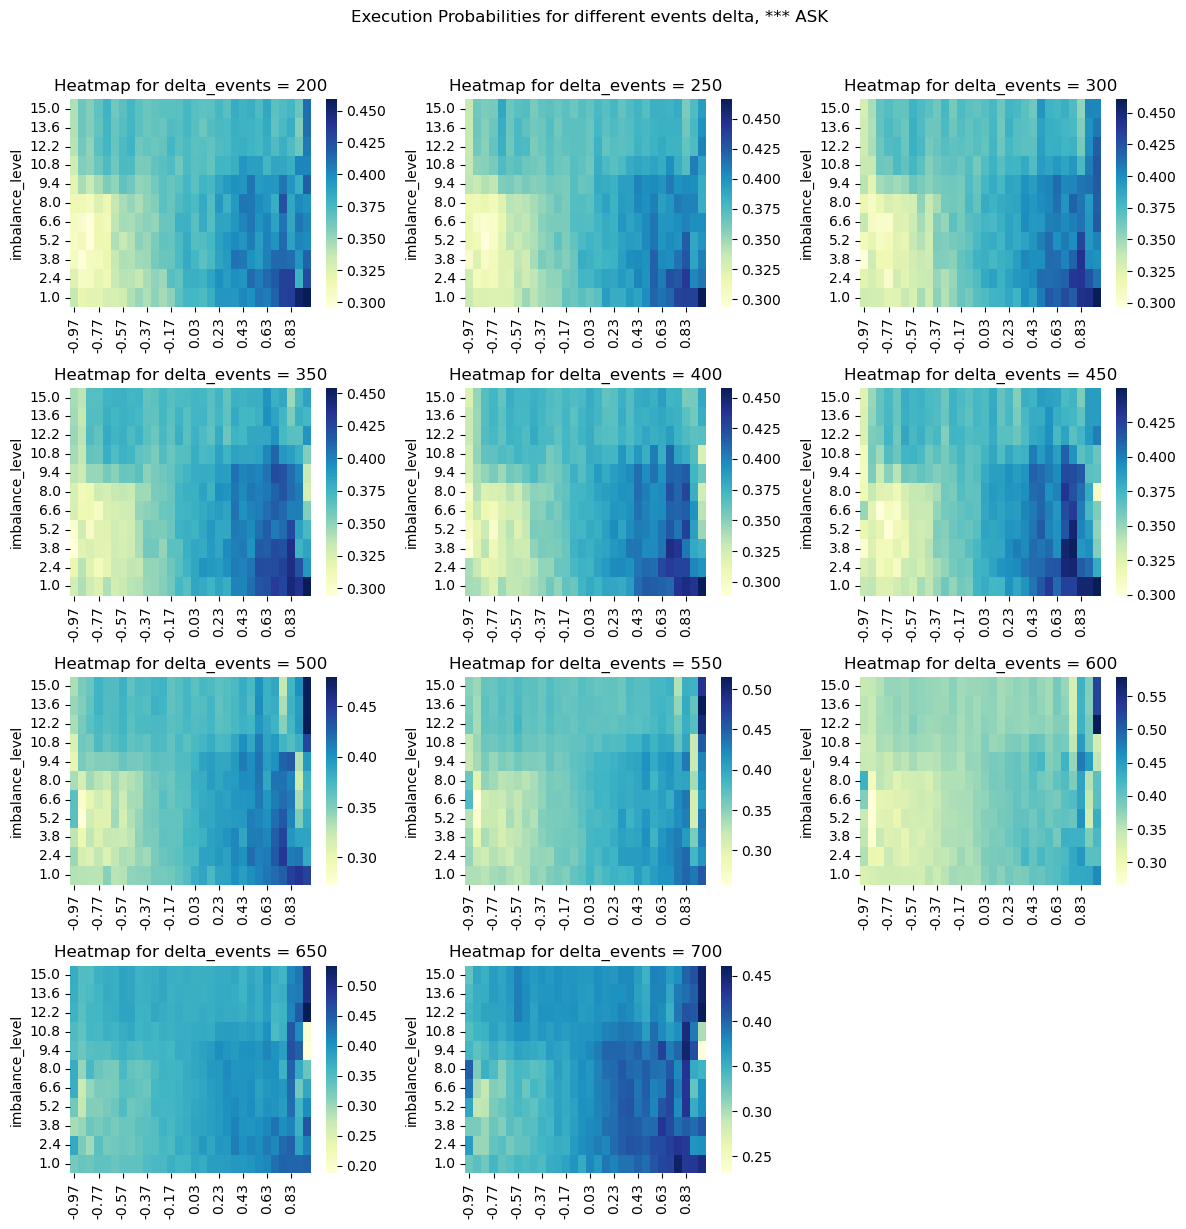

In [9]:
# get the list of unique delta_t values
try : 
    df_bid_events, df_ask_events = df_bid_events, df_ask_events
except : 
    print('using_cached data')
    
    df_bid_events, df_ask_events = pd.read_csv('../data/df_bid_for_heatmap_event.csv', index_col=(0,1)), pd.read_csv('../data/df_ask_for_heatmap_event.csv', index_col= (0,1))



delta_events_list = DELTA_EVENTS_LIST

# number of rows and columns for the subplots
n = len(delta_events_list)
ncols = 3 # number of columns
nrows = int(np.ceil(n / ncols))  # number of rows

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3))


axes = axes.flatten()


for idx, delta_events in enumerate(delta_events_list):
    df_subset = df_bid_events.xs(delta_events, level='delta_events')
    sns.heatmap(df_subset, cmap="YlGnBu", ax=axes[idx]) 
    axes[idx].set_title(f'Heatmap for delta_events = {delta_events}')
    axes[idx].invert_yaxis()


if len(delta_events_list) < len(axes):
    for idx in range(len(delta_events_list), len(axes)):
        fig.delaxes(axes[idx])


fig.suptitle(f'Execution Probabilities for different events delta, *** BID ',y=1.02)        

plt.tight_layout()
plt.show()

##########################################

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3))


axes = axes.flatten()


for idx, delta_events in enumerate(delta_events_list):
    df_subset = df_ask_events.xs(delta_events, level='delta_events')
    sns.heatmap(df_subset, cmap="YlGnBu", ax=axes[idx]) 
    axes[idx].set_title(f'Heatmap for delta_events = {delta_events}')
    axes[idx].invert_yaxis()


if len(delta_events_list) < len(axes):
    for idx in range(len(delta_events_list), len(axes)):
        fig.delaxes(axes[idx])


fig.suptitle(f'Execution Probabilities for different events delta, *** ASK  ',y=1.02)        

plt.tight_layout()
plt.show()

In [10]:
df_bid_events.head()

-0.97     -0.90     -0.83     -0.77  \
delta_events imbalance_level                                           
200          1.0              0.315325  0.279990  0.268951  0.257525   
             2.4              0.285589  0.264977  0.254704  0.254049   
             3.8              0.268579  0.250912  0.254296  0.248786   
             5.2              0.261516  0.255039  0.245561  0.232198   
             6.6              0.263666  0.252852  0.240771  0.231649   

                                 -0.70     -0.63     -0.57     -0.50  \
delta_events imbalance_level                                           
200          1.0              0.254930  0.245563  0.251724  0.243483   
             2.4              0.252388  0.262819  0.245178  0.244716   
             3.8              0.249933  0.250149  0.239394  0.238663   
             5.2              0.240905  0.237716  0.241596  0.235610   
             6.6              0.236246  0.235596  0.232977  0.246340   

                                 -0.43     -0.37  ...      0.37      0.43  \
delta_events imbalance_level                      ...                       
200          1.0              0.239228  0.229503  ...  0.198749  0.194759   
             2.4              0.244133  0.233973  ...  0.187609  0.195354   
             3.8              0.237279  0.234998  ...  0.199943  0.200797   
             5.2              0.231140  0.235642  ...  0.195883  0.199081   
             6.6              0.227553  0.233476  ...  0.198975  0.202923   

                                  0.50      0.57      0.63      0.70  \
delta_events imbalance_level                                           
200          1.0              0.182053  0.195217  0.186564  0.181026   
             2.4              0.203015  0.186357  0.175045  0.173162   
             3.8              0.190546  0.186430  0.184578  0.169624   
             5.2              0.201240  0.189397  0.185259  0.175986   
             6.6              0.197056  0.191361  0.180745  0.176492   

                                  0.77      0.83      0.90      0.97  
delta_events imbalance_level                                          
200          1.0              0.192785  0.180905  0.165549  0.178970  
             2.4              0.176490  0.167290  0.146532  0.141892  
             3.8              0.175078  0.162486  0.146272  0.136919  
             5.2              0.173478  0.156287  0.149437  0.135723  
             6.6              0.168007  0.168293  0.148148  0.134349  

[5 rows x 30 columns]

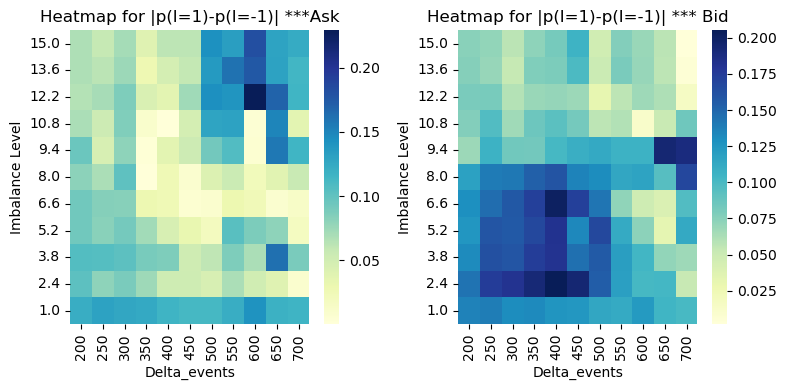

In [11]:


cols = list(df_bid_events.columns)
min_col, max_col = cols[0], cols[-1]

df_heat_map_diff_ask = pd.DataFrame({delta_t : {level  : 0 for level in DEPTHS } for delta_t in DELTA_EVENTS_LIST}).T
df_heat_map_diff_bid = pd.DataFrame({delta_t : {level  : 0 for level in DEPTHS } for delta_t in DELTA_EVENTS_LIST}).T

for delta_event in DELTA_EVENTS_LIST :
    for level in DEPTHS:
        df_heat_map_diff_bid.loc[delta_event,level] = abs(df_bid_events.loc[(delta_event, level), max_col] - df_bid_events.loc[(delta_event, level), min_col])
        df_heat_map_diff_ask.loc[delta_event,level] = abs(df_ask_events.loc[(delta_event, level), max_col] - df_ask_events.loc[(delta_event, level), min_col])



fig, axes = plt.subplots(1, 2, figsize=(8, 4)) 

sns.heatmap(df_heat_map_diff_ask.T, cmap="YlGnBu", ax=axes[0])  
axes[0].set_title(f'Heatmap for |p(I=1)-p(I=-1)| ***Ask')
axes[0].invert_yaxis()
axes[0].set_xlabel('Delta_events') # X-axis label
axes[0].set_ylabel('Imbalance Level') # Y-axis label

sns.heatmap(df_heat_map_diff_bid.T, cmap="YlGnBu", ax=axes[1]) 
axes[1].set_title(f'Heatmap for |p(I=1)-p(I=-1)| *** Bid')
axes[1].invert_yaxis()
axes[1].set_xlabel('Delta_events') 
axes[1].set_ylabel('Imbalance Level') 

plt.tight_layout()
plt.show()

    


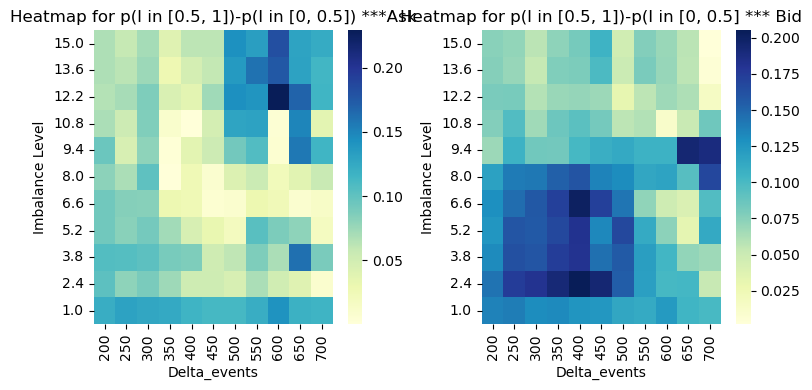

In [12]:
# Now, on coupe en deux [0,1] et on regarde p(I in [0.5, 1])-p(I in [0, 0.5])

cols = list(df_bid_events.columns)
half_num_cols= len(cols)//2
min_col, max_col = cols[0], cols[-1]

df_heat_map_diff_ask_mean = pd.DataFrame({delta_t : {level  : 0 for level in DEPTHS } for delta_t in DELTA_EVENTS_LIST}).T
df_heat_map_diff_bid_mean = pd.DataFrame({delta_t : {level  : 0 for level in DEPTHS } for delta_t in DELTA_EVENTS_LIST}).T

for delta_event in DELTA_EVENTS_LIST :
    for level in DEPTHS:
        df_heat_map_diff_bid_mean.loc[delta_event,level] = sum(
            (df_bid_events.loc[(delta_event, level), cols[i]] - 
             df_bid_events.loc[(delta_event, level), cols[-1-i]]) for i in range(half_num_cols)) 
        

        df_heat_map_diff_ask_mean.loc[delta_event,level] = sum(
            (df_ask_events.loc[(delta_event, level), cols[i]] - 
             df_ask_events.loc[(delta_event, level), cols[-1-i]]) for i in range(half_num_cols)) 



fig, axes = plt.subplots(1, 2, figsize=(8, 4)) 

sns.heatmap(df_heat_map_diff_ask.T, cmap="YlGnBu", ax=axes[0])  
axes[0].set_title(f'Heatmap for p(I in [0.5, 1])-p(I in [0, 0.5]) ***Ask')
axes[0].invert_yaxis()
axes[0].set_xlabel('Delta_events') # X-axis label
axes[0].set_ylabel('Imbalance Level') # Y-axis label

sns.heatmap(df_heat_map_diff_bid.T, cmap="YlGnBu", ax=axes[1]) 
axes[1].set_title(f'Heatmap for p(I in [0.5, 1])-p(I in [0, 0.5] *** Bid')
axes[1].invert_yaxis()
axes[1].set_xlabel('Delta_events') 
axes[1].set_ylabel('Imbalance Level') 

plt.tight_layout()
plt.show()

In [17]:
# decide on the layout of your subplots
n_rows = len(df_bid_events.index.get_level_values('delta_events').unique())
n_cols = len(df_ask_events.index.get_level_values('imbalance_level').unique())

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*8, n_rows*6))


axes = axes.flatten()


# iterate through your sets of parameters
for i, (delta_event, imbalance_level) in enumerate(df_bid_events.index):
    
    sns.scatterplot(x=list(df_bid_events.columns), y=list(df_bid_events.loc[delta_event, imbalance_level]), color='green', ax=axes[i], s = 30)
    sns.scatterplot(x=list(df_ask_events.columns), y=list(df_ask_events.loc[delta_event, imbalance_level]), color='red', ax=axes[i], s = 30)
    axes[i].set_title(f'exec proba for {delta_event} events and {imbalance_level} bps',)
    # set the title of each subplot as the parameters tuple
    
if len(df_bid_events.index) < len(axes):
    for idx in range(len(df_bid_events.index), len(axes)):
        fig.delaxes(axes[idx])

# add a title for the whole figure
fig.suptitle(f'Execution Probabilities for different levels and tick distance ', y = 1.02)

# improve layout
plt.tight_layout()
plt.savefig('../images/output')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './images/output.png'

In [15]:
## Now with spline univariate : 


# decide on the layout of your subplots
index_delta = df_bid_events.index.get_level_values('delta_events').unique()
index_imbalance = df_bid_events.index.get_level_values('imbalance_level').unique()
x_ = [float(x) for x in list(df_bid_events.columns)]
    

n_rows = len(index_delta)
n_cols = len(index_imbalance)

delta_to_level_to_diff_ask_events = {delta_event : {level  : 0 for level in index_imbalance } for delta_event in index_delta}
delta_to_level_to_diff_bid_events = {delta_event : {level  : 0 for level in index_imbalance } for delta_event in index_delta}

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*8, n_rows*6))


axes = axes.flatten()



# iterate through your sets of parameters
for i, (delta_event, imbalance_level) in enumerate(df_bid_events.index):
    y_bid = list(df_bid_events.loc[delta_event, imbalance_level])
    y_ask = list(df_ask_events.loc[delta_event, imbalance_level])


    spl_bid = UnivariateSpline(x_, y_bid)
    spl_ask = UnivariateSpline(x_, y_ask)

    spl_bid.set_smoothing_factor(0.05)
    spl_ask.set_smoothing_factor(0.05)

    delta_to_level_to_diff_bid_events[delta_event][imbalance_level]= abs(spl_bid(x_[0]) - spl_bid(x_[-1]))
    delta_to_level_to_diff_ask_events[delta_event][imbalance_level]= abs(spl_ask(x_[0]) - spl_bid(x_[-1]))


    sns.scatterplot(x = x_, y = y_bid, color = 'green', ax = axes[i], s = 10)
    sns.scatterplot(x = x_, y = y_ask, color = 'red', ax = axes[i] , s = 10)

    sns.lineplot(x = x_, y = spl_bid(x_), color='green', ax = axes[i])
    sns.lineplot(x = x_, y = spl_ask(x_), color='red', ax = axes[i])
    axes[i].set_title(f'exec proba for {delta_event} events and {imbalance_level} bps')
    # set the title of each subplot as the parameters tuple
    
if len(df_bid_events.index) < len(axes):
    for idx in range(len(df_bid_events.index), len(axes)):
        fig.delaxes(axes[idx])

# add a title for the whole figure
fig.suptitle(f'Execution Probabilities for different levels and tick distance, for a delay in events',y=1.02)

# improve layout
plt.tight_layout()
plt.savefig('../images/output_splined_event')
plt.show()







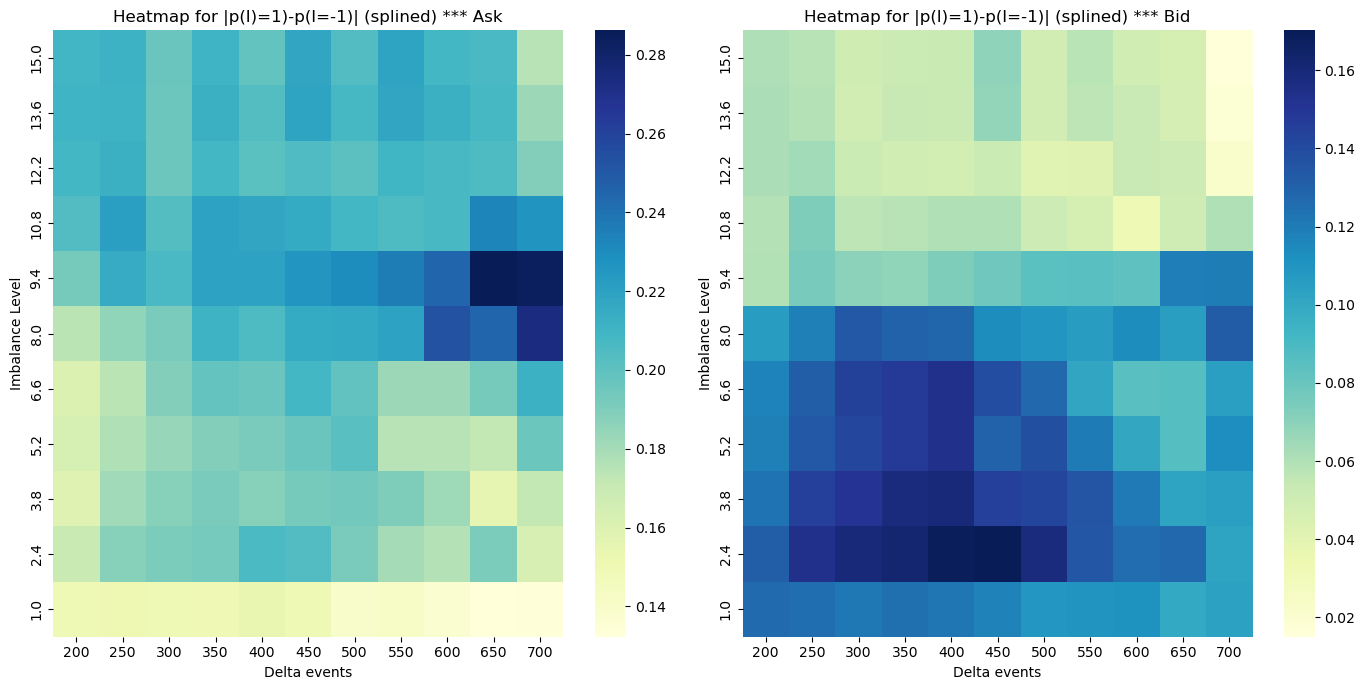

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7)) 

sns.heatmap(pd.DataFrame(delta_to_level_to_diff_ask_events), cmap="YlGnBu", ax=axes[0])  
axes[0].set_title(f'Heatmap for |p(I)=1)-p(I=-1)| (splined) *** Ask')
axes[0].invert_yaxis()
axes[0].set_xlabel('Delta events') # X-axis label
axes[0].set_ylabel('Imbalance Level') # Y-axis label

sns.heatmap(pd.DataFrame(delta_to_level_to_diff_bid_events), cmap="YlGnBu", ax=axes[1])  
axes[1].set_title(f'Heatmap for |p(I)=1)-p(I=-1)| (splined) *** Bid')
axes[1].invert_yaxis()
axes[1].set_xlabel('Delta events') # X-axis label
axes[1].set_ylabel('Imbalance Level') # Y-axis label

plt.savefig('heatmap_splined_p1-p-1_event')


plt.tight_layout()
plt.show()